[![Test](https://github.com/tmbdev/webdataset/workflows/Test/badge.svg)](https://github.com/tmbdev/webdataset/actions?query=workflow%3ATest)
[![DeepSource](https://static.deepsource.io/deepsource-badge-light-mini.svg)](https://deepsource.io/gh/tmbdev/webdataset/?ref=repository-badge)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn
from random import randrange
import os
os.environ["WDS_VERBOSE_CACHE"] = "1"

# The WebDataset Format

WebDataset reads dataset that are stored as tar files, with the simple convention that files that belong together and make up a training sample share the same basename. WebDataset can read files from local disk or from any pipe, which allows it to access files using common cloud object stores. WebDataset can also read concatenated MsgPack and CBORs sources.

The WebDataset representation allows writing purely sequential I/O pipelines for large scale deep learning. This is important for achieving high I/O rates from local storage (3x-10x for local drives compared to random access) and for using object stores and cloud storage for training.

The WebDataset format represents images, movies, audio, etc. in their native file formats, making the creation of WebDataset format data as easy as just creating a tar archive. Because of the way data is aligned, WebDataset works well with block deduplication as well and aligns data on predictable boundaries.

Standard tools can be used for accessing and processing WebDataset-format files.

In [2]:
%%bash
curl -s http://storage.googleapis.com/nvdata-openimages/openimages-train-000000.tar | tar tf - | sed 10q

e39871fd9fd74f55.jpg
e39871fd9fd74f55.json
f18b91585c4d3f3e.jpg
f18b91585c4d3f3e.json
ede6e66b2fb59aab.jpg
ede6e66b2fb59aab.json
ed600d57fcee4f94.jpg
ed600d57fcee4f94.json
ff47e649b23f446d.jpg
ff47e649b23f446d.json


# Related Projects

- the new `torchdata` library in PyTorch will add native (built-in) support for WebDataset
- the AIStore server provides high-speed storage, caching, and data transformation for WebDataset data
- WebDataset training can be carried out directly against S3, GCS, and other cloud storage buckets
- NVIDIA's DALI library supports reading WebDataset format data directly
- there is a companion project to read WebDataset data in Julia
- the `tarp` command line program can be used for quick and easy dataset transformations of WebDataset data

# WebDataset

WebDataset makes it easy to write I/O pipelines for large datasets. Datasets can be stored locally or in the cloud.

When your data is stored in the cloud, by default, local copies are downloaded and cached when you open the remote dataset.

In [3]:
import webdataset as wds

In [4]:
url = "http://storage.googleapis.com/nvdata-publaynet/publaynet-train-{000000..000009}.tar"
dataset = wds.WebDataset(url).shuffle(1000).decode("rgb").to_tuple("png", "json")

The resulting datasets are standard PyTorch `IterableDataset` instances.

In [5]:
isinstance(dataset, torch.utils.data.IterableDataset)

True

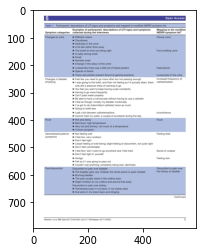

In [6]:
for image, json in dataset:
    break
plt.imshow(image)

Let's add some code to transform the input data.

In [7]:
def preprocess(sample):
    image, json = sample
    try:
        label = json["annotations"][0]["category_id"]
    except:
        label = 0
    return 1-image, label

dataset = dataset.map(preprocess)

1


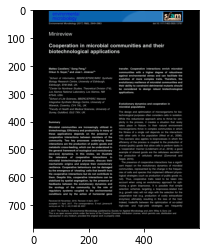

In [8]:
for image, label in dataset:
    break
plt.imshow(image)
print(label)

Note that this uses the fluid interface to WebDataset, a convenient shorthand for a lot of training loops. We'll see later what this expands to.

# Expanding Samples

Let's add another processing pipeline stage; this one expands a single large input sample into multiple smaller samples. We shuffle the newly generated sub-samples further to mix up sub-samples from different images in the stream.

This uses the `.compose` method, which takes a function that maps an interator over samples into another iterator over samples.

In [9]:
def get_patches(src):
    for sample in src:
        image, label = sample
        h, w = image.shape[:2]
        for i in range(16):
            y, x = randrange(h-256), randrange(w-265)
            patch = image[y:y+256, x:x+256]
            yield (patch, label)
        
dataset = dataset.compose(get_patches).shuffle(10000)

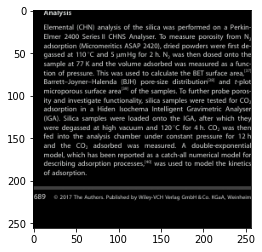

In [10]:
for image, json in dataset:
    break
    
plt.imshow(image)

# DataLoader

`WebDataset` is just an instance of a standard `IterableDataset`. It's a single-threaded way of iterating over a dataset.

Since image decompression and data augmentation can be compute intensive, PyTorch usually uses the `DataLoader` class to parallelize data loading and preprocessing. `WebDataset` is fully compatible with the standard `DataLoader`.

In [11]:
loader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size=8)

batch = next(iter(loader))
batch[0].shape, batch[1].shape

(torch.Size([8, 256, 256, 3]), torch.Size([8]))

The `webdataset` library contains a small wrapper that adds a fluid interface to the `DataLoader` (and is otherwise identical).

This comes in handy if you want to shuffle across dataset instances and allows you to change batch size dynamically.

In [12]:
loader = wds.WebLoader(dataset, num_workers=4, batch_size=8)
loader = loader.unbatched().shuffle(1000).batched(12)

batch = next(iter(loader))
batch[0].shape, batch[1].shape

(torch.Size([12, 256, 256, 3]), torch.Size([12]))

It is generally most efficient to avoid batching in the `DataLoader` altogether; instead, batch in the dataset and then rebatch after the loader.

A complete pipeline then looks like this.

In [13]:
url = "http://storage.googleapis.com/nvdata-publaynet/publaynet-train-{000000..000009}.tar"
dataset = wds.WebDataset(url).shuffle(1000).decode("rgb").to_tuple("png", "json").map(preprocess)
dataset = dataset.compose(get_patches)
dataset = dataset.batched(16)

loader = wds.WebLoader(dataset, num_workers=4, batch_size=8)
loader = loader.unbatched().shuffle(1000).batched(12)

batch = next(iter(loader))
batch[0].shape, batch[1].shape

(torch.Size([12, 16, 256, 256, 3]), torch.Size([12, 16]))

# Pipeline Interface

The `wds.WebDataset` fluid interface is just a convenient shorthand for writing down pipelines. The underlying pipeline is an instance of the `wds.DataPipeline` class, and you can construct data pipelines explicitly, similar to the way you use `nn.Sequential` inside models.

In [14]:
dataset = wds.DataPipeline(
    wds.SimpleShardList(url),
    # at this point we have an iterator over all the shards
    wds.shuffle(100),
    wds.split_by_worker,
    # at this point, we have an iterator over the shards assigned to each worker
    wds.tarfile_to_samples(),
    wds.shuffle(1000),
    wds.decode("torchrgb"),
    # at this point, we have an list of decompressed training samples from each shard in this worker in sequence
    get_patches,  # note that can put iterator->iterator functions into the pipeline directly
    wds.shuffle(10000),
    wds.to_tuple("big.jpg", "json"),
    wds.batched(16)
)

batch = next(iter(loader))
batch[0].shape, batch[1].shape

(torch.Size([12, 16, 256, 256, 3]), torch.Size([12, 16]))

# Multinode Training

Multinode training in PyTorch and other frameworks is complex. It depends on how exactly you distribute training across nodes, whether you want to keep "exact epochs" (exactly and only one sample from the dataset per epoch), and whether your training framework can deal with unequal number of samples per node.

The simplest solution for multinode training is to use a resampling strategy for the shards, generating an infinite stream of samples. You then set the epoch length explicitly with the `.with_epoch` method. 

In [15]:
dataset = wds.WebDataset(url, resampled=True).shuffle(1000).decode("rgb").to_tuple("png", "json").map(preprocess).with_epoch(10000)
sample = next(iter(dataset))

Inside a pipeline, you can do the same thing using the `ResampledShards` generator. Shuffling and splitting by worker are then not needed.

In [16]:
dataset = wds.DataPipeline(
    wds.ResampledShards(url),
    # at this point we have an iterator over all the shards
    wds.tarfile_to_samples(),
    wds.shuffle(1000),
    wds.decode("torchrgb"),
    # at this point, we have an list of decompressed training samples from each shard in this worker in sequence
    get_patches,  # note that can put iterator->iterator functions into the pipeline directly
    wds.shuffle(10000),
    wds.to_tuple("big.jpg", "json"),
    wds.batched(16)
).with_epoch(10000)

batch = next(iter(loader))
batch[0].shape, batch[1].shape

(torch.Size([12, 16, 256, 256, 3]), torch.Size([12, 16]))

# Installation and Documentation

    $ pip install webdataset

For the Github version:

    $ pip install git+https://github.com/tmbdev/webdataset.git

Here are some videos talking about WebDataset and large scale deep learning:

- [Introduction to Large Scale Deep Learning](https://www.youtube.com/watch?v=kNuA2wflygM)
- [Loading Training Data with WebDataset](https://www.youtube.com/watch?v=mTv_ePYeBhs)
- [Creating Datasets in WebDataset Format](https://www.youtube.com/watch?v=v_PacO-3OGQ)
- [Tools for Working with Large Datasets](https://www.youtube.com/watch?v=kIv8zDpRUec)

Examples: (NB: some of these are for older versions of WebDataset, but the differences should be small)

- [loading videos](https://github.com/tmbdev/webdataset/blob/master/docs/video-loading-example.ipynb)
- [splitting raw videos into clips for training](https://github.com/tmbdev/webdataset/blob/master/docs/ytsamples-split.ipynb)
- [converting the Falling Things dataset](https://github.com/tmbdev/webdataset/blob/master/docs/falling-things-make-shards.ipynb)

# Dependencies

The WebDataset library only requires PyTorch, NumPy, and a small library called `braceexpand`.

WebDataset loads a few additional libraries dynamically only when they are actually needed and only in the decoder:

- PIL/Pillow for image decoding
- `torchvision`, `torchvideo`, `torchaudio` for image/video/audio decoding
- `msgpack` for MessagePack decoding
- the `curl` command line tool for accessing HTTP servers
- the Google/Amazon/Azure command line tools for accessing cloud storage buckets

Loading of one of these libraries is triggered by configuring a decoder that attempts to decode content in the given format and encountering a file in that format during decoding. (Eventually, the torch... dependencies will be refactored into those libraries.)

# Data Decoding

Data decoding is a special kind of transformations of samples. You could simply write a decoding function like this:

```Python
def my_sample_decoder(sample):
    result = dict(__key__=sample["__key__"])
    for key, value in sample.items():
        if key == "png" or key.endswith(".png"):
            result[key] = mageio.imread(io.BytesIO(value))
        elif ...:
            ...
    return result

dataset = wds.Processor(wds.map, my_sample_decoder)(dataset)
```

This gets tedious, though, and it also unnecessarily hardcodes the sample's keys into the processing pipeline. To help with this, there is a helper class that simplifies this kind of code. The primary use of `Decoder` is for decoding compressed image, video, and audio formats, as well as unzipping `.gz` files.

Here is an example of automatically decoding `.png` images with `imread` and using the default `torch_video` and `torch_audio` decoders for video and audio:

```Python
def my_png_decoder(key, value):
    if not key.endswith(".png"):
        return None
    assert isinstance(value, bytes)
    return imageio.imread(io.BytesIO(value))

dataset = wds.Decoder(my_png_decoder, wds.torch_video, wds.torch_audio)(dataset)
```

You can use whatever criteria you like for deciding how to decode values in samples. When used with standard `WebDataset` format files, the keys are the full extensions of the file names inside a `.tar` file. For consistency, it's recommended that you primarily rely on the extensions (e.g., `.png`, `.mp4`) to decide which decoders to use. There is a special helper function that simplifies this:

```Python
def my_decoder(value):
    return imageio.imread(io.BytesIO(value))
    
dataset = wds.Decoder(wds.handle_extension(".png", my_decoder))(dataset)
```

# Alternative Representation: CBOR

An alternative representation of collections of samples is based on the IETF CBOR standard, an efficient, binary representation of data structures. CBOR files are particularly useful for large collections of very small samples (data tuples, short strings, etc.)


In [29]:
import cbor
import numpy as np

Writing CBOR files is very easy:

In [30]:
with open("test.cbors", "wb") as stream:
    for i in np.linspace(-5.0, 5.0, 1000):
        cbor.dump((i, str(i)[-5:]), stream)

Of course, you can these files directly:

In [31]:
with open("test.cbors", "rb") as stream:
    for i in range(3):
        print(cbor.load(stream))

[-5.0, '-5.0']
[-4.98998998998999, '98999']
[-4.97997997997998, '97998']


And CBOR files/shards integrate fully into `DataPipeline` with the `cbors_to_samples` function.

In [32]:
dataset = wds.DataPipeline(
    wds.SimpleShardList("test.cbors"),
    wds.cbors_to_samples(),
)
data = list(iter(dataset))
len(data), data[0]

(1000, [-5.0, '-5.0'])

# "Smaller" Datasets and Desktop Computing

WebDataset is an ideal solution for training on petascale datasets kept on high performance distributed data stores like AIStore, AWS/S3, and Google Cloud. Compared to data center GPU servers, desktop machines have much slower network connections, but training jobs on desktop machines often also use much smaller datasets. WebDataset also is very useful for such smaller datasets, and it can easily be used for developing and testing on small datasets and then scaling up to large datasets by simply using more shards.


Here are different usage scenarios:

- **desktop deep learning, smaller datasets**
    - copy all shards to local disk manually
    - use automatic shard caching
- **prototyping, development, testing of jobs for large scale training**
    - copy a small subset of shards to local disk
    - use automatic shard caching with a small subrange of shards
- **cloud training against cloud buckets**
    - use WebDataset directly with remote URLs
- **on premises training with high performance store (e.g., AIStore) and fast networks**
    - use WebDataset directly with remote URLs
- **on premises training with slower object stores and/or slower networks**
    - use automatic shard caching
    

## Direct Copying of Shards

Let's take the OpenImages dataset as an example; it's half a terabyte large. For development and testing, you may not want to download the entire dataset, but you may also not want to use the dataset remotely. With WebDataset, you can just download a small number of shards and use them during development.

In [34]:
!curl -L -s http://storage.googleapis.com/nvdata-openimages/openimages-train-000000.tar > /tmp/openimages-train-000000.tar

In [35]:
dataset = wds.DataPipeline(
    wds.SimpleShardList("/tmp/openimages-train-000000.tar"),
    wds.tarfile_to_samples(),
)
repr(next(iter(dataset)))[:200]

"{'__key__': 'e39871fd9fd74f55', '__url__': '/tmp/openimages-train-000000.tar', 'jpg': b'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x01\\x01\\x01:\\x01:\\x00\\x00\\xff\\xdb\\x00C\\x00\\x06\\x04\\x05\\x06\\x05\\x04\\x06\\x06\\"

Note that the WebDataset class works the same way on local files as it does on remote files. Furthermore, unlike other kinds of dataset formats and archive formats, downloaded datasets are immediately useful and don't need to be unpacked.

# Creating a WebDataset

## Using `tar`

Since WebDatasets are just regular tar files, you can usually create them by just using the `tar` command. All you have to do is to arrange for any files that should be in the same sample to share the same basename. Many datasets already come that way. For those, you can simply create a WebDataset with

```
$ tar --sort=name -cf dataset.tar dataset/
```

If your dataset has some other directory layout, you may need a different file name in the archive from the name on disk. You can use the `--transform` argument to GNU tar to transform file names. You can also use the `-T` argument to read the files from a text file and embed other options in that text file.

## The `tarp create` Command

The [`tarp`](https://github.com/tmbdev/tarp) command is a little utility for manipulating `tar` archives. Its `create` subcommand makes it particularly simple to construct tar archives from files. The `tarp create` command takes a recipe for building
a tar archive that contains lines of the form:

```
archive-name-1 source-name-1
archive-name-2 source-name-2
...
```

The source name can either be a file, "text:something", or "pipe:something".

## Programmatically in Python

You can also create a WebDataset with library functions in this library:

- `webdataset.TarWriter` takes dictionaries containing key value pairs and writes them to disk
- `webdataset.ShardWriter` takes dictionaries containing key value pairs and writes them to disk as a series of shards

Here is a quick way of converting an existing dataset into a WebDataset; this will store all tensors as Python pickles:

```Python
sink = wds.TarWriter("dest.tar")
dataset = open_my_dataset()
for index, (input, output) in dataset:
    sink.write({
        "__key__": "sample%06d" % index,
        "input.pyd": input,
        "output.pyd": output,
    })
sink.close()
```

Storing data as Python pickles allows most common Python datatypes to be stored, it is lossless, and the format is fast to decode.
However, it is uncompressed and cannot be read by non-Python programs. It's often better to choose other storage formats, e.g.,
taking advantage of common image compression formats.

If you know that the input is an image and the output is an integer class, you can also write something like this:

```Python
sink = wds.TarWriter("dest.tar")
dataset = open_my_dataset()
for index, (input, output) in dataset:
    assert input.ndim == 3 and input.shape[2] == 3
    assert input.dtype = np.float32 and np.amin(input) >= 0 and np.amax(input) <= 1
    assert type(output) == int
    sink.write({
        "__key__": "sample%06d" % index,
        "input.jpg": input,
        "output.cls": output,
    })
sink.close()
```

The `assert` statements in that loop are not necessary, but they document and illustrate the expectations for this
particular dataset. Generally, the ".jpg" encoder can actually encode a wide variety of array types as images. The
".cls" encoder always requires an integer for encoding.

Here is how you can use `TarWriter` for writing a dataset without using an encoder:

```Python
sink = wds.TarWriter("dest.tar", encoder=False)
for basename in basenames:
    with open(f"{basename}.png", "rb") as stream):
        image = stream.read()
    cls = lookup_cls(basename)
    sample = {
        "__key__": basename,
        "input.png": image,
        "target.cls": cls
    }
    sink.write(sample)
sink.close()
```

Since no encoder is used, if you want to be able to read this data with the default decoder, `image` must contain a byte string corresponding to a PNG image (as indicated by the ".png" extension on its dictionary key), and `cls` must contain an integer encoded in ASCII (as indicated by the ".cls" extension on its dictionary key).

# Writing Filters and Offline Augmentation

Webdataset can be used for filters and offline augmentation of datasets. Here is a complete example that pre-augments a shard and extracts class labels.

In [36]:
def extract_class(data):
    # mock implementation
    return 0

def augment_wds(input, output, maxcount=999999999):
    src = wds.DataPipeline(
        wds.SimpleShardList(input),
        wds.tarfile_to_samples(),
        wds.decode("pil"),
        wds.to_tuple("__key__", "jpg;png", "json"),
        wds.map_tuple(None, preproc, None),
    )
    with wds.TarWriter(output) as dst:
        for key, image, data in islice(src, 0, maxcount):
            print(key)
            image = image.numpy().transpose(1, 2, 0)
            image -= amin(image)
            image /= amax(image)
            sample = {
                "__key__": key,
                "png": image,
                "cls": extract_class(data)
            }
            dst.write(sample)

Now run the augmentation pipeline:

In [37]:
url = "http://storage.googleapis.com/nvdata-openimages/openimages-train-000000.tar"
url = f"pipe:curl -L -s {url} || true"
augment_wds(url, "_temp.tar", maxcount=5)

e39871fd9fd74f55
f18b91585c4d3f3e
ede6e66b2fb59aab
ed600d57fcee4f94
ff47e649b23f446d


To verify that things worked correctly, let's look at the output file:

In [38]:
%%bash
tar tf _temp.tar

e39871fd9fd74f55.cls
e39871fd9fd74f55.png
f18b91585c4d3f3e.cls
f18b91585c4d3f3e.png
ede6e66b2fb59aab.cls
ede6e66b2fb59aab.png
ed600d57fcee4f94.cls
ed600d57fcee4f94.png
ff47e649b23f446d.cls
ff47e649b23f446d.png


If you want to preprocess the entire OpenImages dataset with a process like this, you can use your favorite job queueing or worflow system.

For example, using Dask, you could process all 554 shards in parallel using code like this:

```Python
shards = braceexpand.braceexpand("{000000..000554}")
inputs = [f"gs://bucket/openimages-{shard}.tar" for shard in shards]
outputs = [f"gs://bucket2/openimages-augmented-{shard}.tar" for shard in shards]
results = [dask.delayed(augment_wds)(args) for args in zip(inputs, outputs)]
dask.compute(*results)
```

Note that the data is streaming from and to Google Cloud Storage buckets, so very little local storage is required on each worker.

For very large scale processing, it's easiest to submit separate jobs to a Kubernetes cluster using the Kubernetes `Job` template, or using a workflow engine like Argo.

Whether you prefer `WebDataset` or `Dataset` is a matter of style.

# Syntax for URL Sources

The `SimpleShardList` and `ResampledShards` take either a string or a list of URLs as an argument. If it is given a string, the string is expanded using the `braceexpand` library. So, the following are equivalent:

```Python
ShardList("dataset-{000..001}.tar")
ShardList(["dataset-000.tar", "dataset-001.tar"])
```

The url strings in a shard list are handled by default by the `webdataset.url_opener` filter. It recognizes three simple kinds of strings: "-", "/path/to/file", and "pipe:command":

- the string "-", referring to stdin
- a UNIX path, opened as a regular file
- a URL-like string with the schema "pipe:"; such URLs are opened with `subprocess.Popen`. For example:
    - `pipe:curl -s -L http://server/file` accesses a file via HTTP
    - `pipe:gsutil cat gs://bucket/file` accesses a file on GCS
    - `pipe:az cp --container bucket --name file --file /dev/stdout` accesses a file on Azure
    - `pipe:ssh host cat file` accesses a file via `ssh`

It might seem at first glance to be "more efficient" to use built-in Python libraries for accessing object stores rather than subprocesses, but efficient object store access from Python really requires spawning a separate process anyway, so this approach to accessing object stores is not only convenient, it also is as efficient as we can make it in Python.

# Related Libraries and Software

The [AIStore](http://github.com/NVIDIA/aistore) server provides an efficient backend for WebDataset; it functions like a combination of web server, content distribution network, P2P network, and distributed file system. Together, AIStore and WebDataset can serve input data from rotational drives distributed across many servers at the speed of local SSDs to many GPUs, at a fraction of the cost. We can easily achieve hundreds of MBytes/s of I/O per GPU even in large, distributed training jobs.

The [tarproc](http://github.com/tmbdev/tarproc) utilities provide command line manipulation and processing of webdatasets and other tar files, including splitting, concatenation, and `xargs`-like functionality.

The [tensorcom](http://github.com/tmbdev/tensorcom/) library provides fast three-tiered I/O; it can be inserted between [AIStore](http://github.com/NVIDIA/aistore) and [WebDataset](http://github.com/tmbdev/webdataset) to permit distributed data augmentation and I/O. It is particularly useful when data augmentation requires more CPU than the GPU server has available.

You can find the full PyTorch ImageNet sample code converted to WebDataset at [tmbdev/pytorch-imagenet-wds](http://github.com/tmbdev/pytorch-imagenet-wds)
